In [1]:
import numpy as np
from joblib import Parallel, delayed
from sklearn.multiclass import _ConstantPredictor
from sklearn.preprocessing import LabelBinarizer
from scipy import special
import lightgbm as lgb


class OneVsRestLightGBMWithCustomizedLoss:

    def __init__(self, loss, n_jobs=3):
        self.loss = loss
        self.n_jobs = n_jobs

    def fit(self, X, y, **fit_params):

        self.label_binarizer_ = LabelBinarizer(sparse_output=True)
        Y = self.label_binarizer_.fit_transform(y)
        Y = Y.tocsc()
        self.classes_ = self.label_binarizer_.classes_
        columns = (col.toarray().ravel() for col in Y.T)
        if 'eval_set' in fit_params:
            # use eval_set for early stopping
            X_val, y_val = fit_params['eval_set'][0]
            Y_val = self.label_binarizer_.transform(y_val)
            Y_val = Y_val.tocsc()
            columns_val = (col.toarray().ravel() for col in Y_val.T)
            self.results_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit_binary)
                                                         (X, column, X_val, column_val, **fit_params) for
                                                         i, (column, column_val) in
                                                         enumerate(zip(columns, columns_val)))
        else:
            # eval set not available
            self.results_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit_binary)
                                                         (X, column, None, None, **fit_params) for i, column
                                                         in enumerate(columns))

        return self

    def _fit_binary(self, X, y, X_val, y_val, **fit_params):
        unique_y = np.unique(y)
        init_score_value = self.loss.init_score(y)
        if len(unique_y) == 1:
            estimator = _ConstantPredictor().fit(X, unique_y)
        else:
            fit = lgb.Dataset(X, y, init_score=np.full_like(y, init_score_value, dtype=float))
            if 'eval_set' in fit_params:
                val = lgb.Dataset(X_val, y_val, init_score=np.full_like(y_val, init_score_value, dtype=float),
                                  reference=fit)

                estimator = lgb.train(params=fit_params,
                                      train_set=fit,
                                      valid_sets=(fit, val),
                                      valid_names=('fit', 'val'),
                                      early_stopping_rounds=10,
                                      fobj=self.loss.lgb_obj,
                                      feval=self.loss.lgb_eval,
                                      verbose_eval=10)
            else:
                estimator = lgb.train(params=fit_params,
                                      train_set=fit,
                                      fobj=self.loss.lgb_obj,
                                      feval=self.loss.lgb_eval,
                                      verbose_eval=10)

        return estimator, init_score_value

    def predict(self, X):

        n_samples = X.shape[0]
        maxima = np.empty(n_samples, dtype=float)
        maxima.fill(-np.inf)
        argmaxima = np.zeros(n_samples, dtype=int)

        for i, (e, init_score) in enumerate(self.results_):
            margins = e.predict(X, raw_score=True)
            prob = special.expit(margins + init_score)
            np.maximum(maxima, prob, out=maxima)
            argmaxima[maxima == prob] = i

        return argmaxima

    def predict_proba(self, X):
        y = np.zeros((X.shape[0], len(self.results_)))
        for i, (e, init_score) in enumerate(self.results_):
            margins = e.predict(X, raw_score=True)
            y[:, i] = special.expit(margins + init_score)
        y /= np.sum(y, axis=1)[:, np.newaxis]
        return y

In [2]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv

import pandas as pd 
from pandas import Series, DataFrame 
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

import time

In [4]:
# Read the data in using Pandas Dataframe and print the variables:
data = pd.read_csv('train.csv')
variables = data.columns
print(variables)

X = data.iloc[:,:-6]
#X.drop(['Date', 'Image File', 'Time', 'Timestamp', 'imgpaths','Particle ID','Elapsed Time',
#        'Image Y','Source Image','Intensity','Sigma Intensity', 'Edge Gradient', 'Capture X', 
#        'Calibration Image', 'Capture Y', 'Sum Intensity', 'Image X',
#        'Aspect Ratio','Image Width','Image Height'],inplace=True,axis=1)

#Niccollo recommends dropping these:
todrop = ['Particle ID',
          'Calibration Factor',
          'Calibration Image',
          'Camera',
          'Capture X',
          'Capture Y',
          'Date',
          'Elapsed Time',
          'Filter Score',
          'Image File',
          'Image Height',
          'Image Width',
          'Image X',
          'Image Y',
          'Source Image',
          'Time',
          'Timestamp',
          'imgpaths'
         ]

X.drop(todrop,inplace=True,axis=1)

#grab the one hot encoded classes
classes_onehot = data.iloc[:,-6:].values
classes_vec = np.nonzero(classes_onehot)[1]
y_label=classes_vec

X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.30, random_state=42,stratify=y_label)

class_dict = {0:'Campanian',1:'Corylus',2:'Dust',3:'Grimsvotn',4:'qrober',5:'qsuber'}
classes =[]
labeles=np.unique(y_label)
for v in labeles:
    classes.append(str(class_dict[v]))
print(classes)

Index(['Particle ID', 'Area (ABD)', 'Area (Filled)', 'Aspect Ratio',
       'Biovolume (Cylinder)', 'Biovolume (P. Spheroid)', 'Biovolume (Sphere)',
       'Calibration Factor', 'Calibration Image', 'Camera', 'Capture X',
       'Capture Y', 'Circle Fit', 'Circularity', 'Circularity (Hu)',
       'Compactness', 'Convex Perimeter', 'Convexity', 'Date',
       'Diameter (ABD)', 'Diameter (ESD)', 'Edge Gradient', 'Elapsed Time',
       'Elongation', 'Feret Angle Max', 'Feret Angle Min', 'Fiber Curl',
       'Fiber Straightness', 'Filter Score', 'Geodesic Aspect Ratio',
       'Geodesic Length', 'Geodesic Thickness', 'Image File', 'Image Height',
       'Image Width', 'Image X', 'Image Y', 'Intensity', 'Length',
       'Particles Per Chain', 'Perimeter', 'Roughness', 'Sigma Intensity',
       'Source Image', 'Sphere Complement', 'Sphere Count', 'Sphere Unknown',
       'Sphere Volume', 'Sum Intensity', 'Symmetry', 'Time', 'Timestamp',
       'Transparency', 'Volume (ABD)', 'Volume (ESD)', 

Prediction accuracy 0.9089616977479354  recall  0.8575280289711835


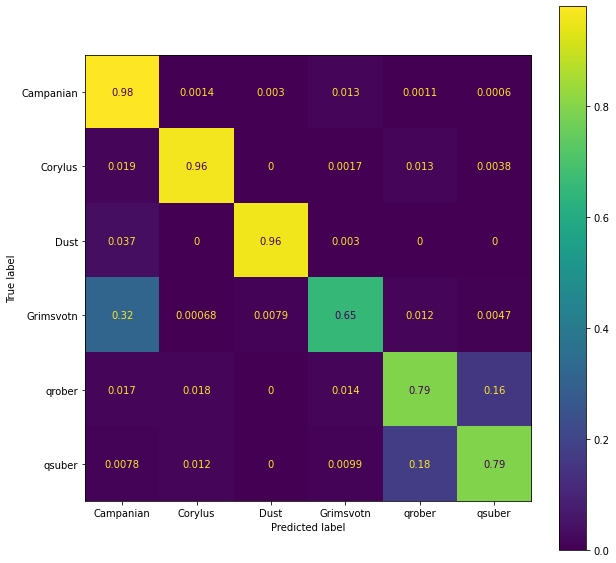

In [11]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,plot_confusion_matrix,ConfusionMatrixDisplay
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
pred_accuracy_score = accuracy_score(y_test, y_test_pred)
pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print('Prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)

cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles)
fig,ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(clf,X_test,y_test, display_labels=classes,normalize='true',ax=ax)#title='Confusion matrix'

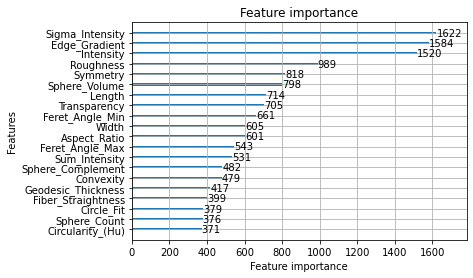

In [6]:
#Find inbuilt feature_importances
lgb.plot_importance(clf,max_num_features=20)


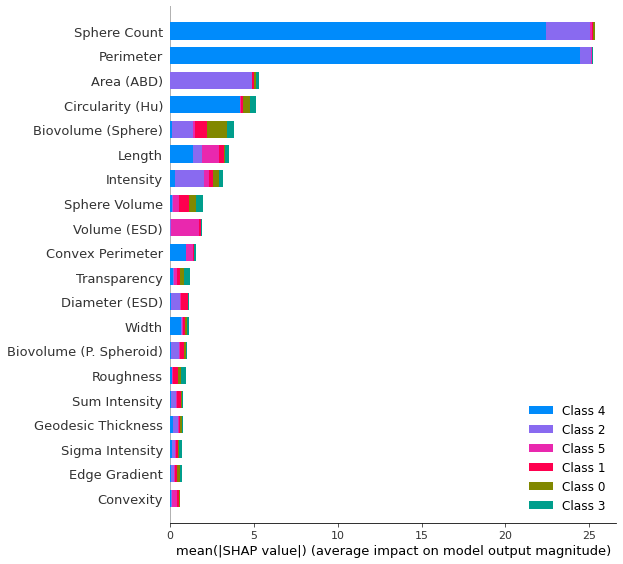

In [12]:
#Setup Shap
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)


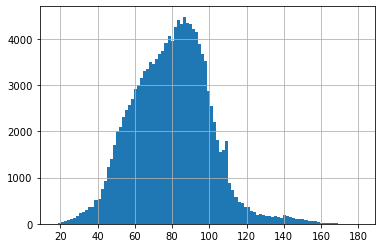

In [7]:
data['Intensity'].hist(bins=100)

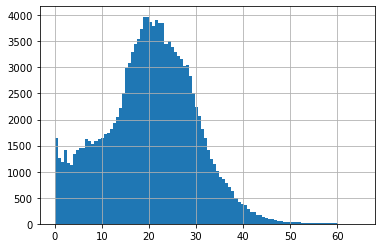

In [8]:
data['Sigma Intensity'].hist(bins=100)

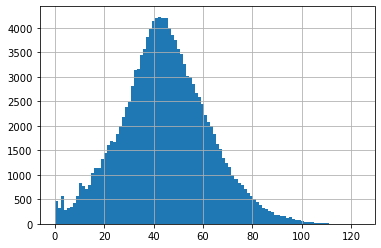

In [9]:
data['Edge Gradient'].hist(bins=100)

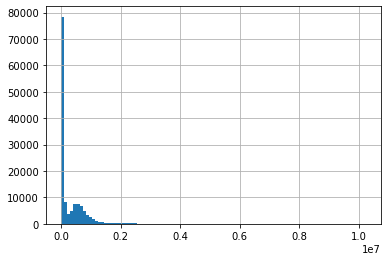

In [10]:
data['Sum Intensity'].hist(bins=100)

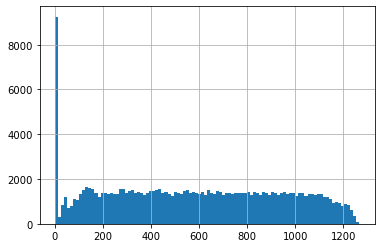

In [11]:
data['Image X'].hist(bins=100)

In [7]:
import numpy as np
from scipy import optimize
from scipy import special

class FocalLoss:

    def __init__(self, gamma, alpha=None):
        self.alpha = alpha
        self.gamma = gamma

    def at(self, y):
        if self.alpha is None:
            return np.ones_like(y)
        return np.where(y, self.alpha, 1 - self.alpha)

    def pt(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, y_true, y_pred):
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, y_true):
        res = optimize.minimize_scalar(
            lambda p: self(y_true, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds

    def lgb_obj(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        return self.grad(y, p), self.hess(y, p)

    def lgb_eval(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        is_higher_better = False
        return 'focal_loss', self(y, p).mean(), is_higher_better

prediction accuracy 0.9085696081554635  recall  0.8556722159127124


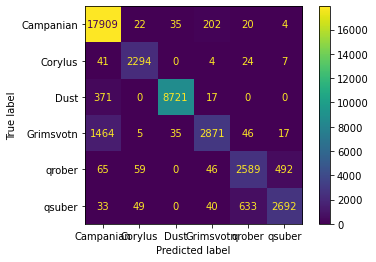

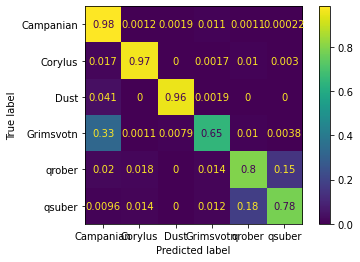

In [9]:
# #from OneVsRestLightGBMWithCustomizedLoss import *
# #from FocalLoss import FocalLoss #get the FocalLoss implementation from Halford's blog

# Instantiate Focal loss
loss = FocalLoss(alpha=0.75, gamma=2.0)

# Not using early stopping
clf = OneVsRestLightGBMWithCustomizedLoss(loss=loss)
#clf.fit(X_train, y_train)

# Using early stopping
fit_params = {'eval_set': [(X_test, y_test)]}
clf.fit(X_train, y_train, **fit_params)

y_test_pred = clf.predict(X_test)
pred_accuracy_score = accuracy_score(y_test, y_test_pred)
pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print('prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)

cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles)
#Normalize cnf_matrix along the predictions/columns
cnf_sum = np.sum(cnf_matrix,axis=1)
cnf_matrix_norm = cnf_matrix / cnf_sum[:,np.newaxis]
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=classes)#,normalize='true'
disp.plot()
disp_norm = ConfusionMatrixDisplay(cnf_matrix_norm, display_labels=classes)#,normalize='true'
disp_norm.plot()
